<a href="https://colab.research.google.com/github/victen18/Colab_Notebook_Projects/blob/main/Real_or_Not%3F_NLP_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predict which Tweets are about real disasters and which ones are not**

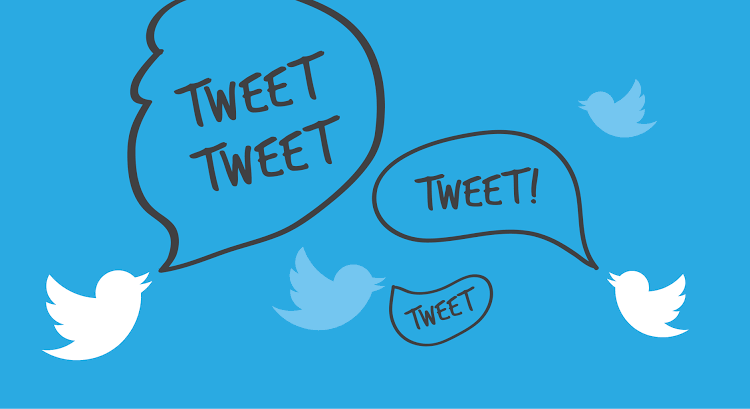

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop = set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import os
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:

tweet = pd.read_csv('/content/gdrive/My Drive/data/train.csv')
test = pd.read_csv('/content/gdrive/My Drive/data/test.csv')
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweet.shape,test.shape

((7613, 5), (3263, 4))

In [5]:
print('There are {} rows and {} columns in tweet'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in tweet
There are 3263 rows and 4 columns in test


## Class distribution

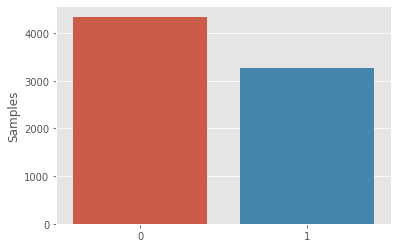

In [6]:
x  = tweet['target'].value_counts()
sns.barplot(x=x.index,y=x)
plt.gca().set_ylabel('Samples')
plt.show()


ohh,as expected ! There is a class distribution.There are more tweets with class 0 ( No disaster) than class 1 ( disaster tweets)

## Exploratory Data Analysis of tweets
First,we will do very basic analysis,that is character level,word level and sentence level analysis.

## Number of characters in tweets


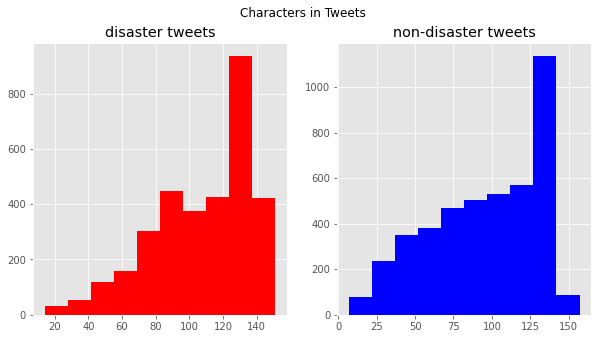

In [7]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = tweet[tweet['target'] == 1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len = tweet[tweet['target'] == 0]['text'].str.len()
ax2.hist(tweet_len,color='blue')
ax2.set_title('non-disaster tweets')
fig.suptitle('Characters in Tweets')
plt.show()

## Number of words in a tweet

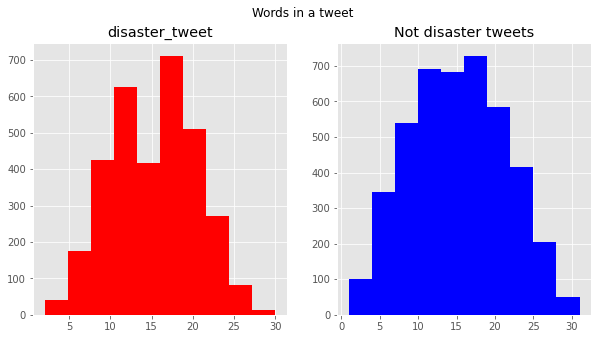

In [8]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = tweet[tweet['target'] == 1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster_tweet')
tweet_len = tweet[tweet['target'] == 0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='blue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()


## Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

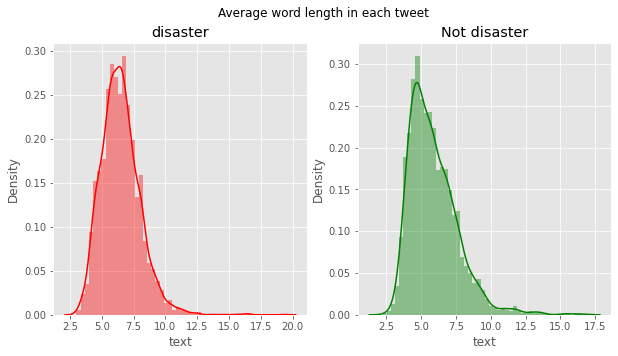

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')


In [10]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

## Common stopwords in tweets

In [11]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

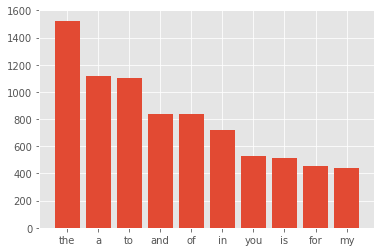

In [12]:
x,y = zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

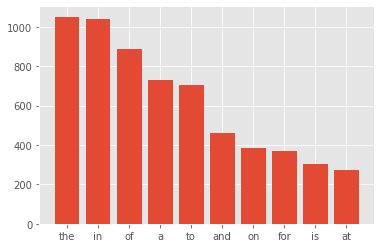

In [13]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

###Analyzing punctuations.

<BarContainer object of 18 artists>

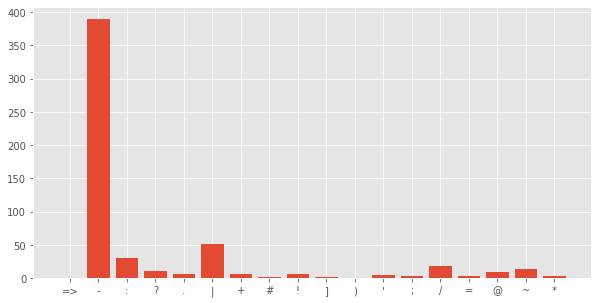

In [14]:
plt.figure(figsize=(10,5))
corpus = create_corpus(1)

dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
  if i in special:
    dic[i]+=1

x,y = zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

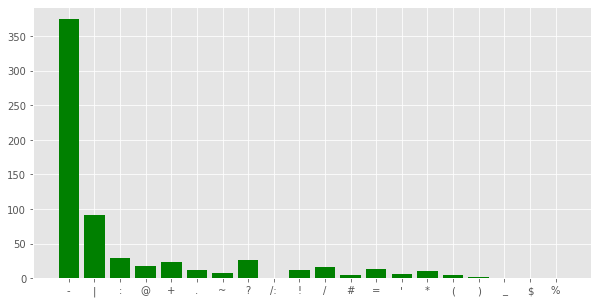

In [15]:
plt.figure(figsize=(10,5))
corpus = create_corpus(0)

dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
  if i in special:
    dic[i]+=1

x,y = zip(*dic.items())
plt.bar(x,y,color='green')

### common words

In [16]:
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []

for word,count in most[:40]:
  if(word not in stop):
    x.append(word)
    y.append(count)

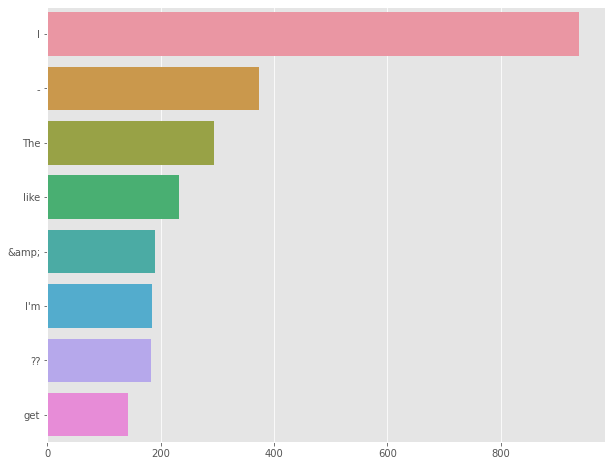

In [17]:
plt.figure(figsize=(10,8))
sns.barplot(x=y,y=x)

###Ngram analysis

we will do a bigram (n=2) analysis over the tweets.Let's check the most common bigrams in tweets.

In [18]:
def get_top_tweet_bigrams(corpus,n=None):
  vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word,sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq,key = lambda x:x[1],reverse=True)
  return words_freq[:n]

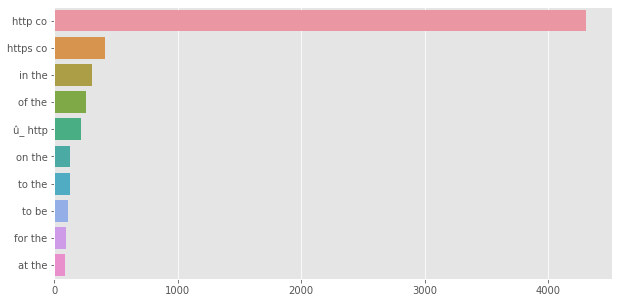

In [19]:
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(tweet['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

##Data Cleaning

In [20]:
df = pd.concat([tweet,test])
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


In [21]:
df.shape

(10876, 5)

###### Removing URLS using Regular Expression

In [22]:
#Code example

example = 'New Competetion launched :https://www.kaggle.com/c/nlp-getting-started '

In [23]:
def remove_URL(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'',text)

remove_URL(example)

'New Competetion launched : '

In [24]:
df['text'] = df['text'].apply(lambda x: remove_URL(x))

##### Removing HTML Tags

In [25]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""


In [26]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [27]:
df['text'] = df['text'].apply(lambda x:remove_html(x))

#####Romoving Emojis

In [28]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [29]:
remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [30]:
df['text'] = df['text'].apply(lambda x:remove_emoji(x))

#####Removing punctuations

In [31]:
def remove_punct(text):
  table = str.maketrans('','',string.punctuation)
  return text.translate(table)

example = 'I am a #king'
remove_punct(example)

'I am a king'

In [32]:
df['text'] = df['text'].apply(lambda x:remove_punct(x))

#####Spelling Correction

In [33]:
!pip install pyspellchecker


     |████████████████████████████████| 1.9MB 6.6MB/s 


In [34]:
from spellchecker import SpellChecker

spell = SpellChecker()

def correct_spelling(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
      if word in misspelled_words:
          corrected_text.append(spell.correction(word))
      else:
          corrected_text.append(word)
    return " ".join(corrected_text)
        

In [35]:
text = "corect me please"
correct_spelling(text)

'correct me please'

In [36]:
#df['text'] = df['text'].apply(lambda x:correct_spelling(x))

##GloVe for Vectorization¶
Here we will use GloVe pretrained corpus model to represent our words.It is available in 3 varieties :50D ,100D and 200 Dimentional.We will try 100 D here.

In [37]:
def create_corpus(df):
  corpus = []
  for tweet in tqdm(df['text']):
    words = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha() == 1) & (word not in stop))]
    corpus.append(words)
  return corpus

In [38]:
corpus = create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 7688.88it/s]


In [40]:
embeding_dict = {}
with open('/content/gdrive/MyDrive/glove/glove.840B.300d.txt','r') as f:
  for line in f:
    values = line.split(' ')
    word = values[0]
    vectors = np.asarray(values[1:],'float32')
    embeding_dict[word] = vectors
f.close()

In [41]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

tweet_pad = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [42]:
word_index = tokenizer_obj.word_index
print('Number of unique words: ',len(word_index))

Number of unique words:  20342


In [43]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,300))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embeding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 400737.08it/s]


##BASELINE MODEL

In [44]:
model=Sequential()

embedding=Embedding(num_words,300,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           6102900   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 6,196,405
Trainable params: 93,505
Non-trainable params: 6,102,900
_________________________________________________________________


In [46]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [47]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [48]:
history=model.fit(X_train,y_train,batch_size=4,epochs=25,validation_data=(X_test,y_test),verbose=2)

Epoch 1/25
1618/1618 - 259s - loss: 0.6761 - accuracy: 0.6001 - val_loss: 0.5750 - val_accuracy: 0.7320
Epoch 2/25
1618/1618 - 255s - loss: 0.5304 - accuracy: 0.7577 - val_loss: 0.5389 - val_accuracy: 0.7417
Epoch 3/25
1618/1618 - 258s - loss: 0.5086 - accuracy: 0.7694 - val_loss: 0.5234 - val_accuracy: 0.7513
Epoch 4/25
1618/1618 - 256s - loss: 0.4948 - accuracy: 0.7764 - val_loss: 0.5123 - val_accuracy: 0.7574
Epoch 5/25
1618/1618 - 255s - loss: 0.4807 - accuracy: 0.7920 - val_loss: 0.5048 - val_accuracy: 0.7706
Epoch 6/25
1618/1618 - 258s - loss: 0.4737 - accuracy: 0.7889 - val_loss: 0.4981 - val_accuracy: 0.7732
Epoch 7/25
1618/1618 - 263s - loss: 0.4676 - accuracy: 0.7938 - val_loss: 0.4923 - val_accuracy: 0.7785
Epoch 8/25
1618/1618 - 262s - loss: 0.4599 - accuracy: 0.7997 - val_loss: 0.4896 - val_accuracy: 0.7793
Epoch 9/25
1618/1618 - 263s - loss: 0.4583 - accuracy: 0.8039 - val_loss: 0.4861 - val_accuracy: 0.7811
Epoch 10/25
1618/1618 - 265s - loss: 0.4541 - accuracy: 0.8020 -

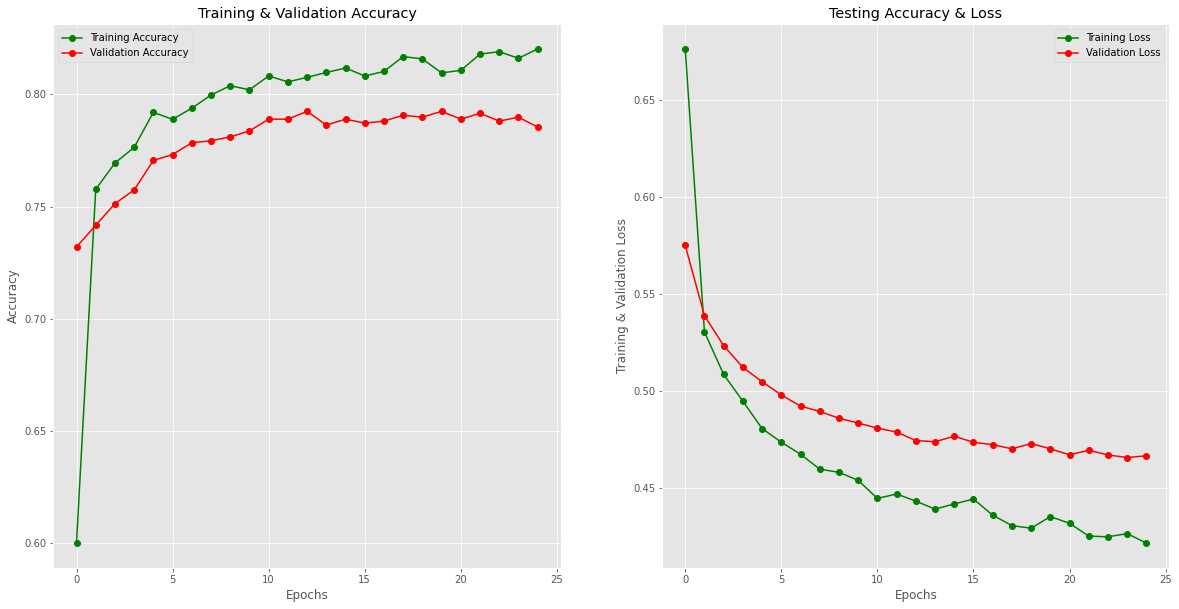

In [50]:
epochs = [i for i in range(25)]
fig,ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()